<a href="https://colab.research.google.com/github/Wyndegarde/MS984/blob/main/Almost_final_draft_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall thoughts:

* Seems this model doesn't predict bitcoin's price very well either. This could be because of the recent high jump in price or because of the model itself. Maybe rerun with different time frame to see. Can see in the graph that the predicted values don't go as high as the actual values right at the end, so it may be the rapid price increase.

* LSTM's apparently are prone to overfitting, so finding and editing the hyperparameters might be a shout. 

* Additionally LSTM's are sensitive to initial weights, and they are randomly set, so without fixing this it will give different results as I saw. 

* ~As mentioned, it may also be an idea to split the training and test data up and then standardising them to prevent any bias.~ **Fixed this** 

* Look at what are the best layers to add. 

* ~should the loss function be "neg_mean_squared_error" instead of "mean_squared_error" ?~ - **No,fine as is, this is defining the loss function not a scoring argument, so you are only defining what the loss will be measured in, you are not trying to minimise MSE**

* Is it possible to figure out how to add in other features for prediction? 

* ~Because of non deterministic nature of adam optimiser, find a way to repeat model fit 30 times and average out results.~ **Done**

* To predict further into the future, you would have to predict a day in advance, add that to the dataset and treat it as historical data, then predict the second day and add that, etc. This means the prediction deteriorates over time. 

# Importing packages and dataset
1. Import all packages used
2. Read in latest bitcoin prices from Yahoo Finance
3. Visualise Bitcoin price through time

In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import os 
import keras 
plt.style.use('fivethirtyeight')

In [3]:
# Get the stock quote
df = web.DataReader("BTC-USD",data_source = 'yahoo',start = '2013-04-28', end = '2021-02-24')
# show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2021-02-21,58330.570312,55672.609375,56068.566406,57539.945312,5.189759e+10,57539.945312
2021-02-22,57533.390625,48967.566406,57532.738281,54207.320312,9.205242e+10,54207.320312
2021-02-23,54204.929688,45290.589844,54204.929688,48824.425781,1.061025e+11,48824.425781


In [51]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-21,58330.570312,55672.609375,56068.566406,57539.945312,5.189759e+10,57539.945312
2021-02-22,57533.390625,48967.566406,57532.738281,54207.320312,9.205242e+10,54207.320312
2021-02-23,54204.929688,45290.589844,54204.929688,48824.425781,1.061025e+11,48824.425781
2021-02-24,51290.136719,47213.500000,48835.085938,49705.332031,6.369552e+10,49705.332031
2021-02-25,51948.968750,47093.851562,49709.082031,47093.851562,5.450657e+10,47093.851562


In [4]:
# get rows and columns
df.shape

(2350, 6)

Text(0, 0.5, 'Close Price USD ($)')

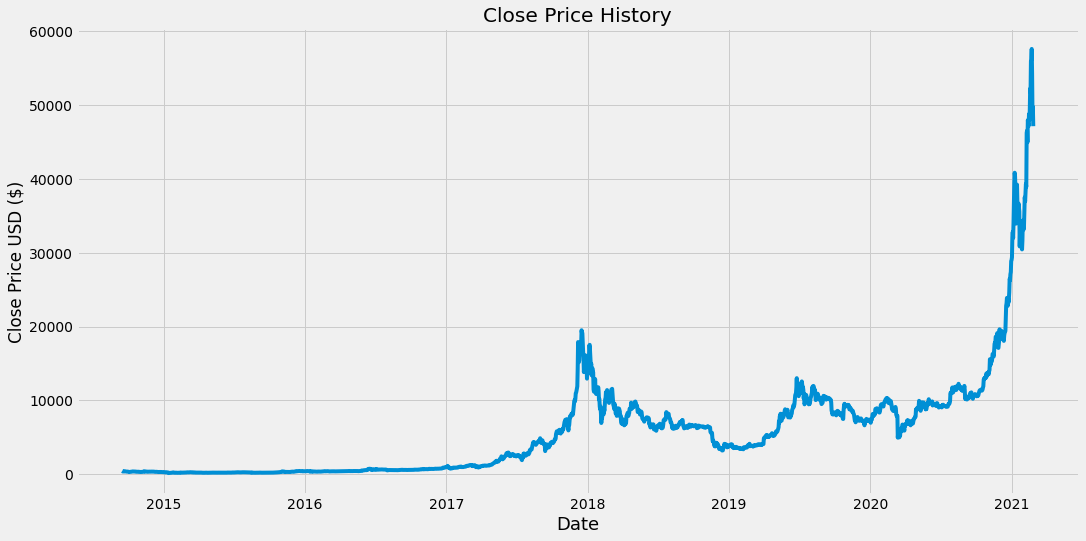

In [5]:
#Visualise the closing price history
plt.figure(figsize = (16,8))
plt.title('Close Price History')
plt.plot(df["Close"])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price USD ($)')

# Creating the Training and Test data
1. split the dataset into training and test set
2. Split each set into x and y variables. 
 - Where each x observation contains the previous 60 days of data.
 - And y is the price of the 61st day
3. Scale independent variables of both training and test set. 

In [6]:
# Create a new dataframe with only closing price
data = df.filter(['Close'])
#Convert dataframe to a numpy array
dataset = data.values
# get number of rows to train model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len 

1880

In [7]:
# Create training dataset
train_data = dataset[0:training_data_len, ]

In [8]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)

In [10]:
# Create the x and Y training values
# X is the previous 60 days of bitcoin price
# Y is the price of the current day (1 day after the 60 days)
x_train = []
y_train = []

for i in range(60, len(train_data)): 
  x_train.append(train_data[i-60:i,0]) #
  y_train.append(train_data[i,0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.01445348, 0.01275083, 0.0112164 , 0.01194666, 0.01142474,
       0.01159716, 0.01333837, 0.0126869 , 0.01208486, 0.01171481,
       0.01146092, 0.01030462, 0.0102159 , 0.01080997, 0.01063765,
       0.01019545, 0.00939004, 0.00780375, 0.00737123, 0.00786654,
       0.0081827 , 0.00904986, 0.00967546, 0.00949615, 0.0095343 ,
       0.01037543, 0.01098958, 0.0115308 , 0.01121521, 0.01058284,
       0.01064506, 0.01104279, 0.01094465, 0.0105978 , 0.01078569,
       0.010614  , 0.00933336, 0.00932964, 0.00875643, 0.00914117,
       0.0090524 , 0.00929201, 0.00815185, 0.00865466, 0.00829316,
       0.00764241, 0.00764981, 0.00773584, 0.00788792, 0.00835346,
       0.00886093, 0.00850507, 0.00866414, 0.00958425, 0.0097737 ,
       0.00981361, 0.01270533, 0.01255905, 0.01137283, 0.01025037])]
[0.010858520753790677]



In [11]:
# Create the testing dataset.
# Create a new array containing scaled values from index 1880 to 2350
test_data = dataset[training_data_len - 60: , :] 
# This here takes all values not in the training set. starts at training length-1 because of the loop before that ends 60 days before the length of training data. 

In [12]:
# Scale the test data
scaler = MinMaxScaler(feature_range=(0,1))
test_data = scaler.fit_transform(test_data)

In [13]:
# Create the data sets x_test and y_test
x_test =[]
y_test = dataset[training_data_len:, :] # don't include the loop because these is no need. 
for i in range(60, len(test_data)):
  x_test.append(test_data[i - 60:i, 0])

# Preparing the training and test data for entry into the LSTM model 

1. LSTM models require input data in a specific format, so independent variables of both sets are converted to this format.

In [14]:
# Convert x_train and y_train to numpy arrays for LSTM model
x_train, y_train = np.array(x_train), np.array(y_train) 

In [15]:
x_train.shape

(1820, 60)

In [17]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1820, 60, 1)

In [19]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [20]:
# Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Building the model 

1. Create layers of model
2. Compile it with optimisation and loss function.
3. Fit the model
4. Save model with best results. 

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))  

In [22]:
#Compile the model
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics = [RootMeanSquaredError()])

In [ ]:
history = model.fit(x_train, y_train, batch_size = 32, epochs=200)

In [1]:
# model.save("Lstm_200epoch_32batch.h5")  - Commenting this out so best model isn't overriden. 

# Model evaluation and prediction 

1. Load the model with best results
2. Find RMSE of test (validation) data.
3. Plot the results of predicting validation data. 
4. Predict and compare Bitcoin Closing value 1 day beyond the dataset.

In [39]:
model = keras.models.load_model("Lstm_200epoch_32batch.h5")

In [40]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

9.75703748337766

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


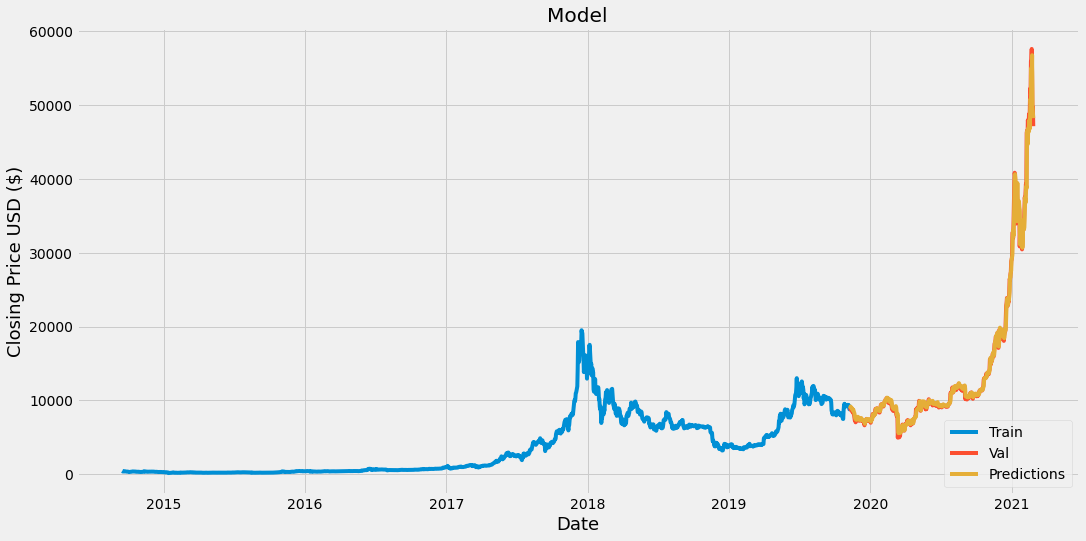

In [41]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualise the model
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Closing Price USD ($)',fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc = 'lower right')
plt.show()

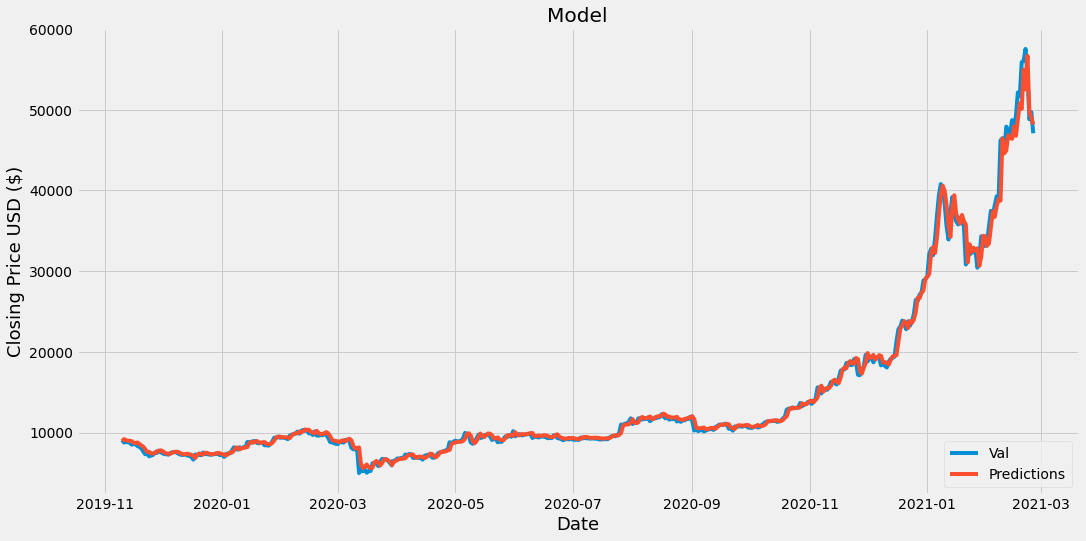

In [42]:
# Plot the data
# Visualise the model
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Closing Price USD ($)',fontsize = 18)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Val','Predictions'],loc = 'lower right')
plt.show()

In [111]:
# Get the quote 
btc_quote = web.DataReader('BTC-USD', data_source = 'yahoo', start = '2013-04-28', end ='2021-02-24')
# Create a new dataframe
new_df = btc_quote.filter(['Close'])
# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list 
days_before_26th = [] 
# append the past 60 days
days_before_26th.append(last_60_days_scaled)
# Convert the days_before_26th data set to a numpy array
days_before_26th = np.array(days_before_26th)
# Reshape the data 
days_before_26th = np.reshape(days_before_26th, (days_before_26th.shape[0],days_before_26th.shape[1],1))
# Get the predicted Scaled Price 
pred_price = model.predict(days_before_26th)
# undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[46902.18]]


In [52]:
btc_quote2 = web.DataReader('BTC-USD', data_source = 'yahoo', start = '2021-02-26', end ='2021-03-01')
print(btc_quote2['Close'])

Date
2021-02-26    46339.761719
2021-02-27    46188.453125
2021-02-28    45137.769531
2021-03-01    49631.242188
2021-03-02    48378.988281
Name: Close, dtype: float64


# Predicting beyond one day

Predicting beyond the 26th requires the previous prediction to be added and treated as a historical value

In [112]:
new_last_60_days = np.append(last_60_days,pred_price)
new_last_60 = new_last_60_days[1:]
new_last_60 = new_last_60.reshape(-1, 1)
new_last_60_days_scaled = scaler.transform(new_last_60)
days_before_27th = [] 

In [113]:
# append the past 60 days
days_before_27th.append(new_last_60_days_scaled)
# Convert the days_before_27th data set to a numpy array
days_before_27th = np.array(days_before_27th)
# Reshape the data 
days_before_27th = np.reshape(days_before_27th, (days_before_27th.shape[0],days_before_27th.shape[1],1))
# Get the predicted Scaled Price 
pred_price = model.predict(days_before_27th)
# undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[46590.766]]


Real price: 46188.453125

In [115]:
pre_28th = np.append(new_last_60_days,pred_price)
before_28th = pre_28th[2:]
before_28th = before_28th.reshape(-1,1)
before_28th_scaled = scaler.transform(before_28th)
days_before_28th = []

In [116]:
# append the past 60 days
days_before_28th.append(before_28th_scaled)
# Convert the days_before_27th data set to a numpy array
days_before_28th = np.array(days_before_28th)
# Reshape the data 
days_before_28th = np.reshape(days_before_28th, (days_before_28th.shape[0],days_before_28th.shape[1],1))
# Get the predicted Scaled Price 
pred_price = model.predict(days_before_28th)
# undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[46206.88]]


real price: 45137.769531

In [117]:
pre_28th

array([27084.80859375, 27362.4375    , 28840.953125  , 29001.72070312,
       29374.15234375, 32127.26757812, 32782.0234375 , 31971.9140625 ,
       33992.4296875 , 36824.36328125, 39371.04296875, 40797.609375  ,
       40254.546875  , 38356.44140625, 35566.65625   , 33922.9609375 ,
       37316.359375  , 39187.328125  , 36825.3671875 , 36178.140625  ,
       35791.27734375, 36630.07421875, 36069.8046875 , 35547.75      ,
       30825.69921875, 33005.76171875, 32067.64257812, 32289.37890625,
       32366.39257812, 32569.84960938, 30432.546875  , 31649.60546875,
       34316.38671875, 34269.5234375 , 33114.359375  , 33537.17578125,
       35510.2890625 , 37472.08984375, 36926.06640625, 38144.30859375,
       39266.01171875, 38903.44140625, 46196.46484375, 46481.10546875,
       44918.18359375, 47909.33203125, 47504.8515625 , 47105.515625  ,
       48717.2890625 , 47945.05859375, 49199.87109375, 52149.0078125 ,
       51679.796875  , 55888.1328125 , 56099.51953125, 57539.9453125 ,
      

In [119]:
pre_1st = np.append(new_last_60_days,pred_price)
before_1st = pre_1st[3:]
before_1st = before_1st.reshape(-1,1)
before_1st_scaled = scaler.transform(before_1st)
days_before_1st = []

In [120]:
# append the past 60 days
days_before_1st.append(before_1st_scaled)
# Convert the days_before_27th data set to a numpy array
days_before_1st = np.array(days_before_1st)
# Reshape the data 
days_before_1st = np.reshape(days_before_1st, (days_before_1st.shape[0],days_before_1st.shape[1],1))
# Get the predicted Scaled Price 
pred_price = model.predict(days_before_1st)
# undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[45806.61]]


Real price: 49631.242188